<a href="https://colab.research.google.com/github/sanj06/BraTS2020_OS/blob/master/BraTS2020_OSprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of Patient Overall Survival in pre-operative MRI scans

Program description : Given a dataset containing pre-operative MRI scans of Brain Tumor and segmented labels, this program trains an <ml model> to predict the Overall Survival(OS) of the patient by extracting imaging/radiomic features.

In [55]:
#import all libaries
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import nibabel as nib
import skimage
from skimage.util import montage

import random
import pandas as pd
!pip install pyradiomics
import os
from radiomics import featureextractor
import radiomics

import keras.backend as K
# import keras
# from ensorflow import keras
from keras import layers
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Maximum,Flatten
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose,UpSampling2D
# from tensorflow.keras.layers.convolutional import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose,UpSampling2D
# from tensorflow.keras.layers.convolutional import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose,UpSampling2D
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D,MaxPooling3D,AveragePooling2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.utils import class_weight
from keras.models import Sequential


# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import csv
import pickle
import cv2
from google.colab.patches import cv2_imshow


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from pprint import pprint
from sklearn import preprocessing


2. Linking Dataset from drive

In [2]:
#link drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


3. Reading and displaying one test image

In [3]:

#read and display first image file
test_image_path = '/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz'

test_img = nib.load(test_image_path)
test_image = nib.load(test_image_path).get_fdata()

print(test_image.shape)

#print(test_img.header)
#print(type(test_image))
print(test_image[120][130])


(240, 240, 155)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 2.
 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [4]:
#function to display image slices
def show_slices(slices):
  fig, axes = plt.subplots(1,len(slices))
  for i, slice in enumerate(slices):
    axes[i].imshow(slice.T, cmap="gray", origin="lower")

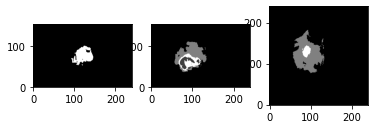

In [5]:
#displaying the image in all axes
slice_0 = test_image[120, :, :]
slice_1 = test_image[:, 120, :]
slice_2 = test_image[:, :, 78]
show_slices([slice_0, slice_1, slice_2])


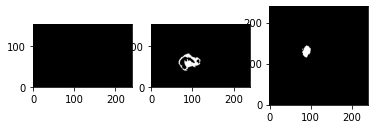

In [6]:
#extracting specific ROI using temp mask
test_image = (test_img.get_fdata()).astype(np.uint8)
temp = np.zeros_like(test_image, dtype=np.uint8)
temp.fill(4) # 4 label is for ET
out = cv2.bitwise_and(test_image, temp)

#displaying specific ROI
slice_out_0 = out[120, :, :]
slice_out_1 = out[:, 120, :]
slice_out_2 = out[:, :, 78]
show_slices([slice_out_0, slice_out_1, slice_out_2])

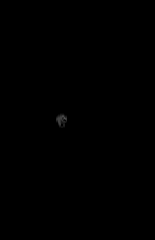

19.990924731182794


In [7]:
#testing how to use laplacian for edge sharpness

#img = cv2.GaussianBlur(slice_0, (11, 11), 0)
laplacian = cv2.Laplacian(out, cv2.CV_64F, ksize=5)
cv2_imshow(laplacian[120])
laplacian_var = laplacian.var()

print(laplacian_var)


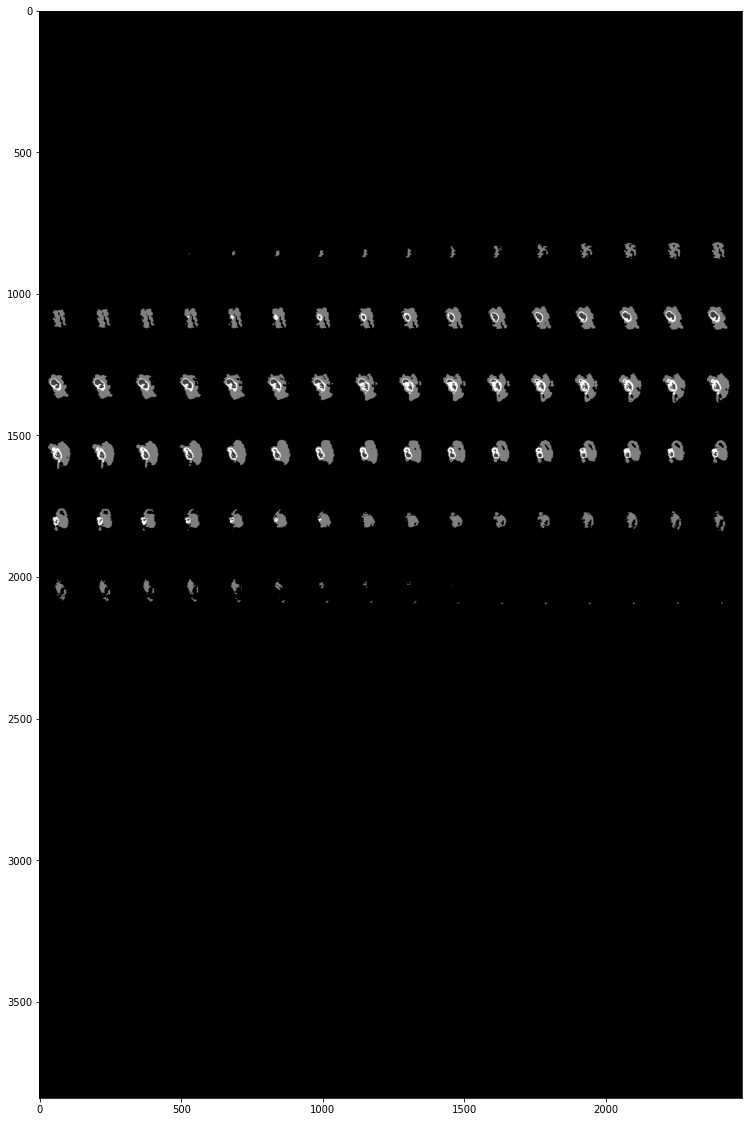

In [8]:
#displaying a montage of the image in x axis
fig, ax1 = plt.subplots(1, 1, figsize = (20, 20))
ax1.imshow(montage(test_image), cmap ='gray')

In [9]:
#creating a separate dataset segregated by modality
#import shutil,os
#dataset_dir_path = '/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
#for training_sample_folder in os.listdir(dataset_dir_path) :
#  if(not(training_sample_folder.endswith(".csv"))):
#    for filename in os.listdir(os.path.join(dataset_dir_path,training_sample_folder)) :
#      x = filename.split('_')
#      image_type = x[3]
#      dir_path = os.path.join(dataset_dir_path,training_sample_folder)
#      if(image_type == "flair.nii.gz"):
#        shutil.copy((os.path.join(dir_path, filename)) , '/content/separate_dataset/flair')
#      if(image_type == "seg.nii.gz"):
#        shutil.copy((os.path.join(dir_path, filename)) , '/content/separate_dataset/seg')
#      if(image_type == 't1ce.nii.gz'):
#        shutil.copy((os.path.join(dir_path, filename)) , '/content/separate_dataset/t1ce')
#      if(image_type == 't1.nii.gz'):
#        shutil.copy((os.path.join(dir_path, filename)) , '/content/separate_dataset/t1')
#      if(image_type == 't2.nii.gz'):
#        shutil.copy((os.path.join(dir_path, filename)) , '/content/separate_dataset/t2')


Check link [Manipulating Brain MRI](https://www.datacamp.com/community/tutorials/reconstructing-brain-images-deep-learning)

In [10]:
'''
#reading survival_info csv file and displaying data 

import csv

survival_info_path = '/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/survival_info.csv'

age_dict = {}
days_dict = {}

with open(survival_info_path, mode='r') as csv_file:
    csv_reader = csv.reader(csv_file,delimiter = ',')
    line_count = 0
    a = 0
    b = 0
    c = 0
    max_days = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            print(row)
            key = row[0]
            age = row[1]
            days = row[2]
            age_dict[key] = float(age)
            days_dict[key] = int(days)
            max_days = max(max_days,int(days))
            if int(days) < 250:
                a += 1
            elif (int(days) >= 250 and int(days) <= 500):
                b += 1
            else:
                c += 1
            line_count+=1

    print(f'Processed {line_count} lines.')
    #age_m = np.zeros((1,1))
    print(a,b,c)
    print(max_days)
'''

'\n#reading survival_info csv file and displaying data \n\nimport csv\n\nsurvival_info_path = \'/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/survival_info.csv\'\n\nage_dict = {}\ndays_dict = {}\n\nwith open(survival_info_path, mode=\'r\') as csv_file:\n    csv_reader = csv.reader(csv_file,delimiter = \',\')\n    line_count = 0\n    a = 0\n    b = 0\n    c = 0\n    max_days = 0\n    for row in csv_reader:\n        if line_count == 0:\n            print(f\'Column names are {", ".join(row)}\')\n            line_count += 1\n        else:\n            print(row)\n            key = row[0]\n            age = row[1]\n            days = row[2]\n            age_dict[key] = float(age)\n            days_dict[key] = int(days)\n            max_days = max(max_days,int(days))\n            if int(days) < 250:\n                a += 1\n            elif (int(days) >= 250 and int(days) <= 500):\n                b += 1\n            else:\n                c += 1\n            line_cou

In [11]:
'''
#Extracting features and storing in features.csv file

survival_info_path = '/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/survival_info.csv'
age_dict = {}
days_dict = {}
keys = []
line_count = 0

#reading survival_info.csv file and storing the given image id's in array, and age and survival days in dict
with open(survival_info_path, mode='r') as csv_file:
    csv_reader = csv.reader(csv_file,delimiter = ',')
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
        else:
          keys.append(row[0])
          age = row[1]
          days = row[2]
          age_dict[row[0]] = float(age)
          days_dict[row[0]] = int(days)         

#print(keys)

#param file and intializing extractors for each ROI

paramPath = os.path.join('/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData', "Params.yaml")
print ("Parameter file, absolute path:", os.path.abspath(paramPath))
#extractor 1 - NCR & NET ROI
settings1 = {'label': 1, 'shape': ['VoxelVolume', 'SurfaceArea', 'MajorAxisLength'], 'firstorder': ['Energy'], 'glcm': ['Contrast'], 'glrlm': ['GrayLevelVariance'], 'glszm': ['GrayLevelVariance'], 'gldm': ['GrayLevelVariance'], 'ngtdm': ['Contrast'],'minimumROISize': 1} #NCR & NET ROI
extractor1 = featureextractor.RadiomicsFeatureExtractor(additionalInfo=True, **settings1)
#extractor 2 - ED ROI
settings2 = {'label': 2, 'shape': ['VoxelVolume', 'SurfaceArea', 'MajorAxisLength'],'firstorder': ['Energy'], 'glcm': ['Contrast'], 'glrlm': ['GrayLevelVariance'], 'glszm': ['GrayLevelVariance'], 'gldm': ['GrayLevelVariance'], 'ngtdm': ['Contrast'],'minimumROISize': 1} #ED ROI
extractor2 = featureextractor.RadiomicsFeatureExtractor(additionalInfo=True, **settings2)
#extractor 3 - ET ROI
settings3 = {'label': 4, 'shape': ['VoxelVolume', 'SurfaceArea', 'MajorAxisLength'], 'firstorder': ['Energy'], 'glcm': ['Contrast'], 'glrlm': ['GrayLevelVariance'], 'glszm': ['GrayLevelVariance'], 'gldm': ['GrayLevelVariance'], 'ngtdm': ['Contrast'],'minimumROISize': 1} #ET ROI
extractor3 = featureextractor.RadiomicsFeatureExtractor(additionalInfo=True, **settings3)

count=0

#fetching flair and seg files and assigning to extractor
dataset_dir_path = '/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

with open('/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/features_data.csv', 'w', newline='') as csvfile:
      writer_var = csv.writer(csvfile, delimiter=',')
      #writer_var.writerow(['Age', 'NCR_VoxelVolume', 'ED_VoxelVolume', 'ET_VoxelVolume','NCR_SurfaceArea', 'ED_SurfaceArea' , 'ET_SurfaceArea','NCR_MajorAxisLength', 'ED_MajorAxisLength', 'ET_MajorAxisLength', 'ET_Laplacian', 'Survival_Days'])
      for id in keys:
        print(id)
        training_sample = os.path.join(dataset_dir_path,id) 
        for filename in os.listdir(training_sample):
          x = filename.split('_')
          image_type = x[3]
          if(image_type == "flair.nii.gz"):
            flair_file = filename
          if(image_type == "seg.nii.gz"):
            seg_file = filename

        # Store the file paths of testing image and label map into two variables
        imagePath = os.path.join(training_sample, flair_file)
        maskPath = os.path.join(training_sample, seg_file)

        #load mask file (seg) and create a temp mask to extract each ROI
        image = (nib.load(maskPath).get_fdata()).astype(np.uint8)
        temp = np.zeros_like(image, dtype=np.uint8)
        temp.fill(4)
        out = cv2.bitwise_and(image, temp)
        #if ROI present extract features else enter 0's
        if 4 in out:          
          result3 = extractor3.execute(imagePath, maskPath)
          ET_VoxelVolume = result3['original_shape_VoxelVolume']
          ET_SurfaceArea = result3['original_shape_SurfaceArea']
          ET_MajorAxisLength = result3['original_shape_MajorAxisLength']
          ET_Laplacian = cv2.Laplacian(out, cv2.CV_64F, ksize=5).var()
        else:
          ET_VoxelVolume, ET_SurfaceArea, ET_MajorAxisLength, ET_Laplacian = 0, 0, 0, 0
        
        
        temp.fill(2)
        out = cv2.bitwise_and(image, temp)
        if 2 in out:          
          result2 = extractor2.execute(imagePath, maskPath)
          ED_VoxelVolume = result2['original_shape_VoxelVolume']
          ED_SurfaceArea = result2['original_shape_SurfaceArea']
          ED_MajorAxisLength = result2['original_shape_MajorAxisLength']
        else:
          ED_VoxelVolume, ED_SurfaceArea, ED_MajorAxisLength  = 0, 0, 0

        
        temp.fill(1)
        out = cv2.bitwise_and(image, temp)
        if 1 in out:          
          result1 = extractor1.execute(imagePath, maskPath)
          NCR_VoxelVolume = result1['original_shape_VoxelVolume']
          NCR_SurfaceArea = result1['original_shape_SurfaceArea']
          NCR_MajorAxisLength = result1['original_shape_MajorAxisLength']
        else:
          NCR_VoxelVolume, NCR_SurfaceArea, NCR_MajorAxisLength  = 0, 0, 0

        #store extracted features and other features in features.csv
        writer_var.writerow([age_dict[id], NCR_VoxelVolume, ED_VoxelVolume, ET_VoxelVolume, NCR_SurfaceArea, ED_SurfaceArea , ET_SurfaceArea, NCR_MajorAxisLength, ED_MajorAxisLength, ET_MajorAxisLength, ET_Laplacian, days_dict[id]])
'''


'\n#Extracting features and storing in features.csv file\n\nsurvival_info_path = \'/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/survival_info.csv\'\nage_dict = {}\ndays_dict = {}\nkeys = []\nline_count = 0\n\n#reading survival_info.csv file and storing the given image id\'s in array, and age and survival days in dict\nwith open(survival_info_path, mode=\'r\') as csv_file:\n    csv_reader = csv.reader(csv_file,delimiter = \',\')\n    for row in csv_reader:\n        if line_count == 0:\n            line_count += 1\n        else:\n          keys.append(row[0])\n          age = row[1]\n          days = row[2]\n          age_dict[row[0]] = float(age)\n          days_dict[row[0]] = int(days)         \n\n#print(keys)\n\n#param file and intializing extractors for each ROI\n\nparamPath = os.path.join(\'/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData\', "Params.yaml")\nprint ("Parameter file, absolute path:", os.path.abspath(paramPath))\n#extractor 

MODELS


In [12]:
# Read and Prepare data

features_path = "/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/features_data.csv"
features_file = open(features_path, "rt")
dataset = np.loadtxt(features_file, delimiter=",")


# split data into X and y
X = dataset[:,0:11]
Y = dataset[:,11]

#print(X)
#print(Y)

In [76]:
#Saved models file path
LR_model = '/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/finalized_LR.sav'  
RF_model = '/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/finalized_RF_new.sav'
XGB_model = '/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/finalized_XGB.sav'
LRNORM_model = '/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/finalized_LRNORM.sav'  
RFNORM_model = '/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/finalized_RFNORM_new.sav'
XGBNORM_model = '/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/finalized_XGBNORM.sav'

#Results file paths
LR_predictions_file = "/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/LR_predictions.csv"
RF_predictions_file = "/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/RF_predictions.csv"
XGB_predictions_file = "/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/XGB_predictions.csv"
stats_file = "/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/stats.csv"

Linear Regression Model


In [70]:
#Linear Regression Model
seed = 0
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

model = LinearRegression() 
model.fit(X_train, y_train)
#save model
pickle.dump(model, open(LR_model, 'wb'))

#Linear Regression on normalized data
X_train_norm = preprocessing.normalize(X_train)
model = LinearRegression() 
model.fit(X_train_norm, y_train)
#save model
pickle.dump(model, open(LRNORM_model, 'wb'))



Random Forest Model

In [59]:
#Finding the best params
'''
 
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)



# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)


rf_random.best_params_
'''

"\n \n# Number of trees in random forest\nn_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]\n# Number of features to consider at every split\nmax_features = ['auto', 'sqrt']\n# Maximum number of levels in tree\nmax_depth = [int(x) for x in np.linspace(10, 110, num = 11)]\nmax_depth.append(None)\n# Minimum number of samples required to split a node\nmin_samples_split = [2, 5, 10]\n# Minimum number of samples required at each leaf node\nmin_samples_leaf = [1, 2, 4]\n# Method of selecting samples for training each tree\nbootstrap = [True, False]\n# Create the random grid\nrandom_grid = {'n_estimators': n_estimators,\n               'max_features': max_features,\n               'max_depth': max_depth,\n               'min_samples_split': min_samples_split,\n               'min_samples_leaf': min_samples_leaf,\n               'bootstrap': bootstrap}\npprint(random_grid)\n\n\n\n# Use the random grid to search for best hyperparameters\n# First create the base mo

In [71]:
# Random Forest Regressor 

seed = 0
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)  

RFregressor = RandomForestRegressor(random_state=0 , n_estimators = 100)
RFregressor.fit(X_train, y_train) 
#save model
pickle.dump(RFregressor, open(RF_model, 'wb'))


#Random Forest on normalized data
X_train_norm = preprocessing.normalize(X_train)
RFregressor = RandomForestRegressor(random_state=0 , n_estimators = 100)
RFregressor.fit(X_train_norm, y_train)
#save model
pickle.dump(RFregressor, open(RFNORM_model, 'wb'))



XGBoost Model

In [72]:
#XGBoost Regressor

seed = 0
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

xgb_regressor = XGBRegressor(learning_rate= 0.1,  subsample = 0.69, eval_metric = 'rmse', verbose = 2)
xgb_regressor.fit(X_train, y_train, eval_metric='rmse')
#save model
pickle.dump(xgb_regressor, open(XGB_model, 'wb'))

#Random Forest on normalized data
X_train_norm = preprocessing.normalize(X_train)
xgb_regressor = XGBRegressor(learning_rate= 0.1,  subsample = 0.69, eval_metric = 'rmse', verbose = 2)
xgb_regressor.fit(X_train_norm, y_train, eval_metric='rmse')
#save model
pickle.dump(xgb_regressor, open(XGBNORM_model, 'wb'))



#df = pd.DataFrame({'LR_Actual': y_test.flatten(), 'LR_Predicted': predictions_LR})
#df.to_csv(predictions)


[17:38:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:38:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Prediction of Values

In [73]:
#predict values and calculate metrics


X_test_norm = preprocessing.normalize(X_test)

#predicting values using saved LR model
loaded_model = pickle.load(open(LR_model, 'rb'))
y_pred = loaded_model.predict(X_test)
predictions_LR = [round(value) for value in y_pred]

LR_mse = mean_squared_error(y_test, predictions_LR, squared=False)
LR_r_square = r2_score(y_test, predictions_LR)
LR_mae = mean_squared_error(y_test, predictions_LR)

LR_metrics = [LR_mse, LR_r_square, LR_mae]

#predicting values using saved LR model with Normalized values
loaded_model = pickle.load(open(LRNORM_model, 'rb'))
y_pred = loaded_model.predict(X_test_norm)
predictions_LRNORM = [round(value) for value in y_pred]

LRNORM_mse = mean_squared_error(y_test, predictions_LRNORM, squared=False)
LRNORM_r_square = r2_score(y_test, predictions_LRNORM)
LRNORM_mae = mean_squared_error(y_test, predictions_LRNORM)

LRNORM_metrics = [LRNORM_mse, LRNORM_r_square, LRNORM_mae]


#Predicting values using saved RF model
loaded_model = pickle.load(open(RF_model, 'rb'))
y_pred = loaded_model.predict(X_test)
predictions_RF = [round(value) for value in y_pred]

RF_mse = mean_squared_error(y_test, predictions_RF, squared=False)
RF_r_square = r2_score(y_test, predictions_RF)
RF_mae = mean_squared_error(y_test, predictions_RF)

RF_metrics = [RF_mse, RF_r_square, RF_mae]

#predicting values using saved RF model with Normalized values
loaded_model = pickle.load(open(RFNORM_model, 'rb'))
y_pred = loaded_model.predict(X_test_norm)
predictions_RFNORM = [round(value) for value in y_pred]

RFNORM_mse = mean_squared_error(y_test, predictions_RFNORM, squared=False)
RFNORM_r_square = r2_score(y_test, predictions_RFNORM)
RFNORM_mae = mean_squared_error(y_test, predictions_RFNORM)

RFNORM_metrics = [RFNORM_mse, RFNORM_r_square, RFNORM_mae]


#Predicting values using saved XGB model
loaded_model = pickle.load(open(XGB_model, 'rb'))
y_pred = loaded_model.predict(X_test)
predictions_XGB = [round(value) for value in y_pred]

XGB_mse = mean_squared_error(y_test, predictions_XGB, squared=False)
XGB_r_square = r2_score(y_test, predictions_XGB)
XGB_mae = mean_squared_error(y_test, predictions_XGB)

XGB_metrics = [XGB_mse, XGB_r_square, XGB_mae]


#predicting values using saved XGB model with Normalized values
loaded_model = pickle.load(open(XGBNORM_model, 'rb'))
y_pred = loaded_model.predict(X_test_norm)
predictions_XGBNORM = [round(value) for value in y_pred]

XGBNORM_mse = mean_squared_error(y_test, predictions_XGBNORM, squared=False)
XGBNORM_r_square = r2_score(y_test, predictions_XGBNORM)
XGBNORM_mae = mean_squared_error(y_test, predictions_XGBNORM)

XGBNORM_metrics = [XGBNORM_mse, XGBNORM_r_square, XGBNORM_mae]

[17:38:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:38:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [74]:
#store metric results 
metrics_info = ['RMSE', 'R2', 'MAE']

stats_df = pd.DataFrame({'Metrics': metrics_info, 'LR': LR_metrics, 'LR NORM': LRNORM_metrics,'RF': RF_metrics, 'RF NORM': RFNORM_metrics, 'XGB': XGB_metrics, 'XGB NORM': XGBNORM_metrics})
stats_df.to_csv(stats_file)

In [77]:
#store predicted values
df = pd.DataFrame({'LR_Actual': y_test.flatten(), 'LR_Predicted': predictions_LR,'LRNORM_Predicted': predictions_LRNORM})
df.to_csv(LR_predictions_file)

df = pd.DataFrame({'RF_Actual': y_test.flatten(), 'RF_Predicted': predictions_RF,'RFNORM_Predicted': predictions_RFNORM})
df.to_csv(RF_predictions_file)

df = pd.DataFrame({'XGB_Actual': y_test.flatten(), 'XGB_Predicted': predictions_XGB,'XGBNORM_Predicted': predictions_XGBNORM})
df.to_csv(XGB_predictions_file)